Синтез данных для анализа. Если есть свои -- пропускайте этот шаг.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Генерация синтетических данных клиентов
def generate_synthetic_client_data(n_clients=10000):
    np.random.seed(42)
    client_ids = np.arange(1, n_clients + 1)
    ages = np.random.randint(18, 70, n_clients)
    genders = np.random.choice(['Male', 'Female'], n_clients)
    locations = np.random.choice(['North', 'South', 'East', 'West'], n_clients)
    interactions = np.random.poisson(10, n_clients)
    churn = np.random.choice([0, 1], n_clients, p=[0.7, 0.3])  # 30% клиентов отказываются

    data = pd.DataFrame({
        'CLIENT_ID': client_ids,
        'AGE': ages,
        'GENDER': genders,
        'LOCATION': locations,
        'INTERACTION_HISTORY': interactions,
        'CHURN': churn
    })
    return data

data = generate_synthetic_client_data()
print(data.head())


   CLIENT_ID  AGE  GENDER LOCATION  INTERACTION_HISTORY  CHURN
0          1   56    Male    North                   12      0
1          2   69  Female     West                   11      0
2          3   46  Female    South                   16      1
3          4   32  Female     East                   12      0
4          5   60    Male     West                   19      0


Анализ данных

         CLIENT_ID           AGE       GENDER  INTERACTION_HISTORY  \
count  10000.00000  10000.000000  10000.00000         10000.000000   
mean    5000.50000     43.539400      0.49780             9.965700   
std     2886.89568     14.911636      0.50002             3.114818   
min        1.00000     18.000000      0.00000             0.000000   
25%     2500.75000     31.000000      0.00000             8.000000   
50%     5000.50000     43.000000      0.00000            10.000000   
75%     7500.25000     56.000000      1.00000            12.000000   
max    10000.00000     69.000000      1.00000            25.000000   

              CHURN  
count  10000.000000  
mean       0.299400  
std        0.458018  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000  
GENDER
0    5022
1    4978
Name: count, dtype: int64


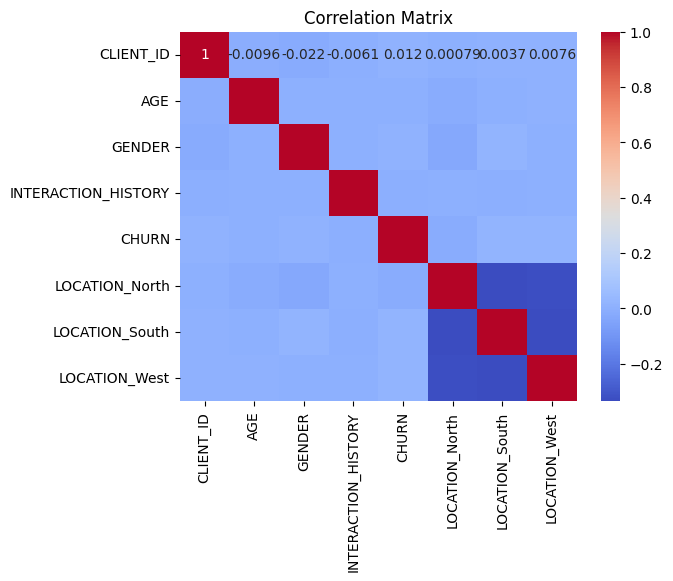

In [10]:
# Преобразование категориальных данных в числовые
label_encoder_gender = LabelEncoder()
data['GENDER'] = label_encoder_gender.fit_transform(data['GENDER'])

data = pd.get_dummies(data, columns=['LOCATION'], drop_first=True)

# Описательная статистика
print(data.describe())
print(data['GENDER'].value_counts())

# Анализ корреляции
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Статистический анализ факторов

In [13]:
# Хи-квадрат тест для категориальных переменных
def chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

chi2_gender = chi2_test(data, 'GENDER', 'CHURN')

print(f"Chi2 test for GENDER and CHURN: Chi2 = {chi2_gender[0]}, p-value = {chi2_gender[1]}")

# Подготовка данных для логистической регрессии
X = data[['AGE', 'GENDER', 'INTERACTION_HISTORY', 'LOCATION_North', 'LOCATION_South', 'LOCATION_West']]
y = data['CHURN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Логистическая регрессия
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# Важность факторов
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


Chi2 test for GENDER and CHURN: Chi2 = 1.2977411848804312, p-value = 0.2546262347231475
              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1397
           1       0.00      0.00      0.00       603

    accuracy                           0.70      2000
   macro avg       0.35      0.50      0.41      2000
weighted avg       0.49      0.70      0.57      2000

               Feature  Importance
5        LOCATION_West    0.120542
4       LOCATION_South    0.103825
1               GENDER    0.021341
0                  AGE    0.000027
2  INTERACTION_HISTORY   -0.000988
3       LOCATION_North   -0.020742


F:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Conda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Визуализация результатов

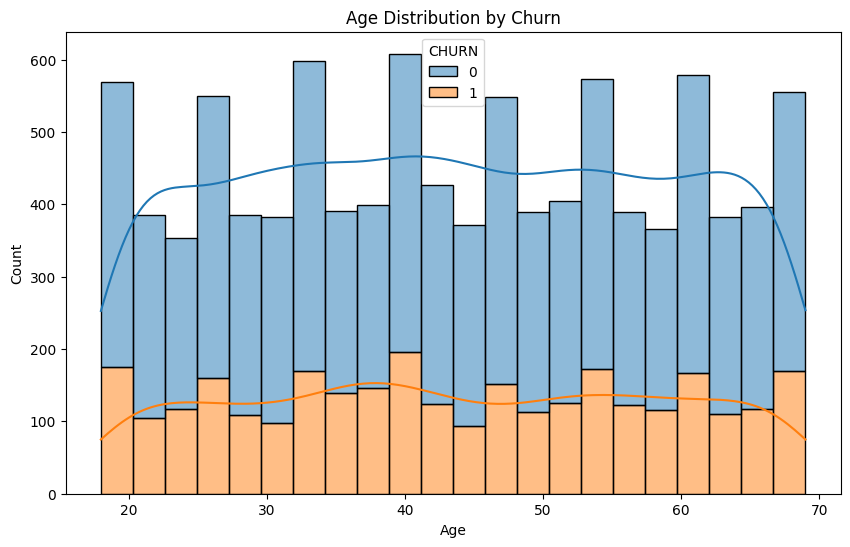

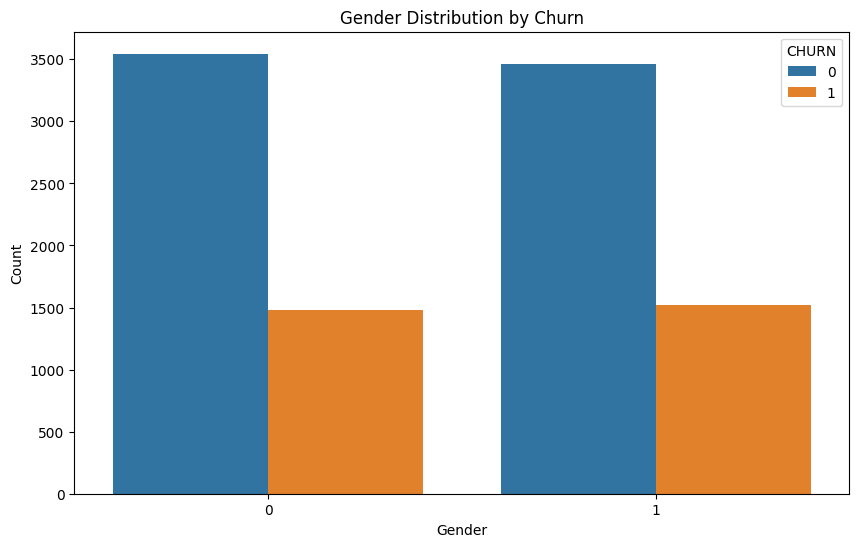

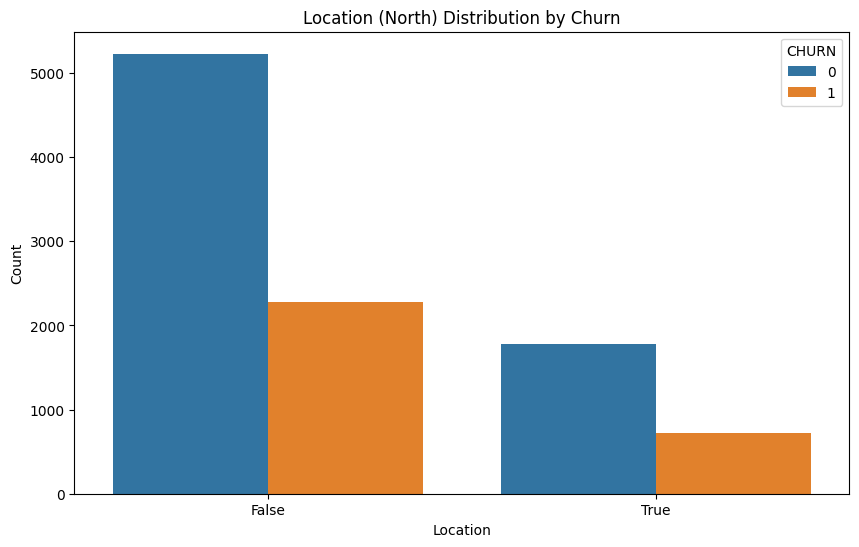

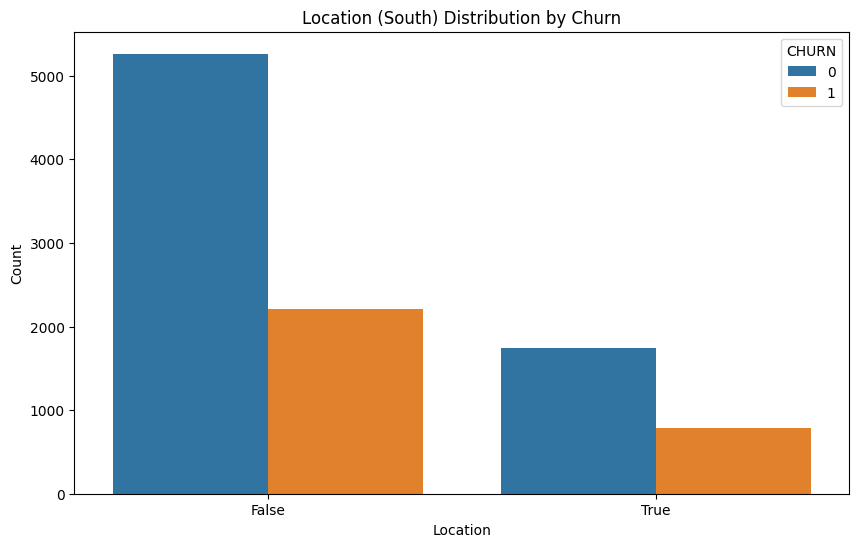

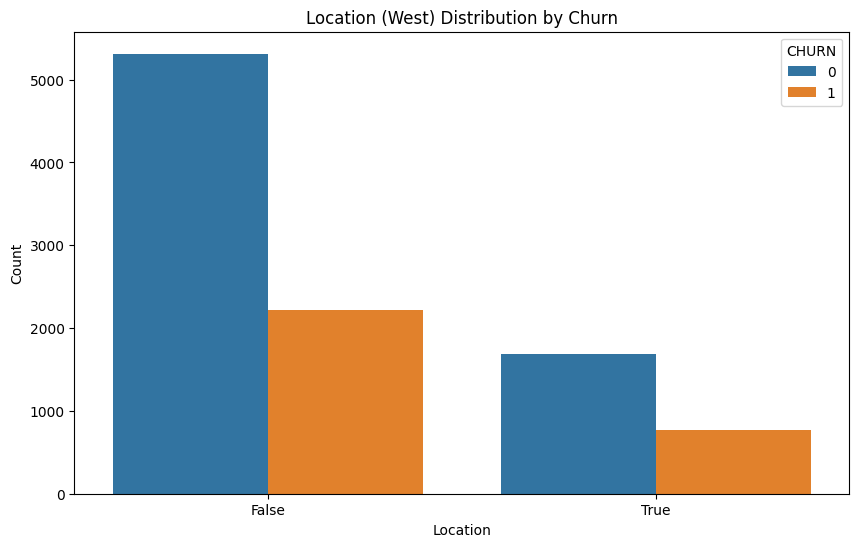

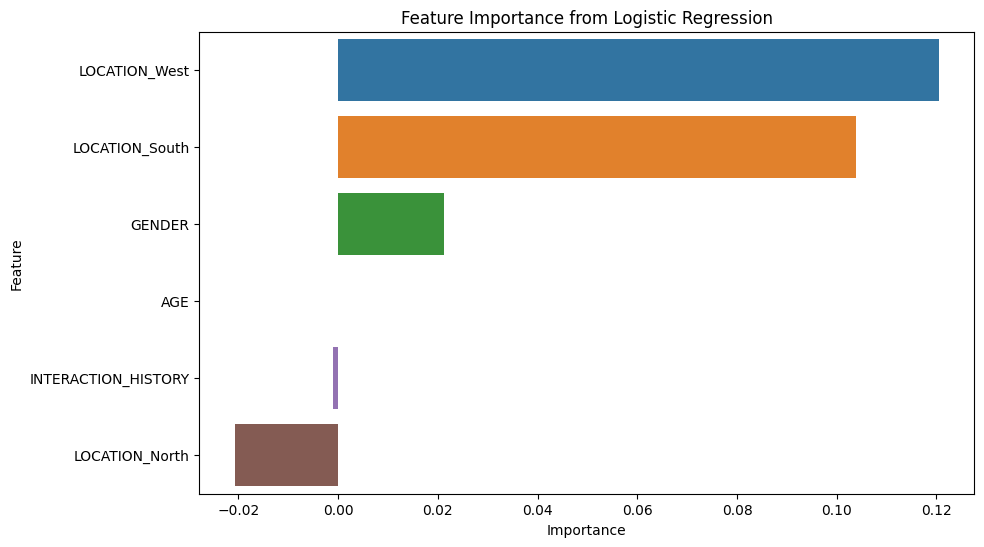

In [18]:
# Визуализация распределения отказов по возрасту
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='AGE', hue='CHURN', multiple='stack', kde=True)
plt.title('Age Distribution by Churn')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Визуализация распределения отказов по полу
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='GENDER', hue='CHURN')
plt.title('Gender Distribution by Churn')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Визуализация распределения отказов по географическому местоположению
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='LOCATION_North', hue='CHURN')
plt.title('Location (North) Distribution by Churn')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='LOCATION_South', hue='CHURN')
plt.title('Location (South) Distribution by Churn')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='LOCATION_West', hue='CHURN')
plt.title('Location (West) Distribution by Churn')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

# Визуализация важности факторов
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Feature Importance from Logistic Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
